In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import gensim

In [89]:
df=pd.read_csv('train.csv')
df=df.sample(frac=1).reset_index(drop=True) # Shuffling the dataset
df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id17093,We stayed here for the last two nights of our ...,Edge,Desktop,happy
1,id19652,We booked this hotel through Priceline (for a ...,Firefox,Desktop,happy
2,id34479,"Love the style of this place, and I don't mean...",Safari,Tablet,happy
3,id25711,"I stayed at The Langham, Boston on Friday July...",InternetExplorer,Mobile,happy
4,id29439,and Warm Cookies too. really nice breakfast bu...,Edge,Tablet,not happy


In [90]:
df=df.iloc[:5000,:] # selecting only 5000 rows as large file will not run in the system
df.shape

(5000, 5)

In [91]:
df['Is_Response'].value_counts()

happy        3439
not happy    1561
Name: Is_Response, dtype: int64

In [92]:
# Dropping columns like user_id, browser used and device used which is of no much importance
df.drop(['User_ID', 'Browser_Used', 'Device_Used'],axis=1,inplace=True) 
df.head()

,Description,Is_Response
0,We stayed here for the last two nights of our ...,happy
1,We booked this hotel through Priceline (for a ...,happy
2,"Love the style of this place, and I don't mean...",happy
3,"I stayed at The Langham, Boston on Friday July...",happy
4,and Warm Cookies too. really nice breakfast bu...,not happy


In [93]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from string import punctuation
import string


In [94]:
df['Description']=df['Description'].str.lower()
#remove punctuation
df['Description']=df['Description'].str.replace(r'[^\w\d\s]',' ')
# Replace whitespace between terms with a single space
df['Description']=df['Description'].str.replace(r'\s+', ' ')
# Remove leading and trailing whitespace
df['Description'] = df['Description'].str.replace(r'^\s+|\s+?$', '')


In [95]:
df['Description']=df['Description'].apply(lambda x: ' '.join(term for term in x.split() if term not in stopwords.words('english')))

print(df['Description'])

0       stayed last two nights west coast tour june su...
1       booked hotel priceline great rate since needed...
2       love style place mean visually although cute m...
3       stayed langham boston friday july st parents s...
4       warm cookies really nice breakfast buffet get ...
                              ...                        
4995    boyfriend recently stayed donatello say enough...
4996    love san francisco wife stayed part honeymoon ...
4997    husband stayed pearl honeymoon read reviews we...
4998    decided hotel difficult find hotel new york wi...
4999    husband returned fantastic stay sofitel celebr...
Name: Description, Length: 5000, dtype: object


In [96]:
positive=[]
negative=[]
neutral=[]
for i in df['Description']:
    sia=SentimentIntensityAnalyzer()
    positive.append(sia.polarity_scores(i)['pos'])
    negative.append(sia.polarity_scores(i)['neg'])
    neutral.append(sia.polarity_scores(i)['neu'])
print(sum(positive))
print(sum(negative))
print(sum(neutral))

1517.5570000000064
275.87700000000024
3206.551


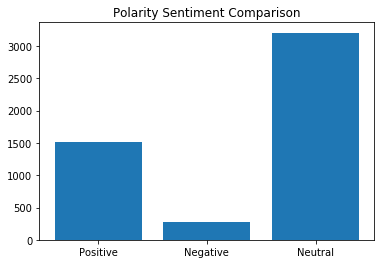

In [97]:
df_polarity=pd.DataFrame({'Positive':[sum(positive)], 'Negative':[sum(negative)], 'Neutral':[sum(neutral)]})
plt.figure()
v=[sum(positive), sum(negative), sum(neutral)]
pol=['Positive','Negative','Neutral']
plt.bar(pol,v)
plt.title('Polarity Sentiment Comparison')
plt.show()

Observation
1. From Polarity Sentiment Comparison, we understood that Neutral score is the highest, which could be normal words used in the reviews and positive scores are more than negative scores.

#### Topic Modelling


In [98]:
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
stemmer=SnowballStemmer("english")


In [99]:
# writing function for entire dataset
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text,pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token)>2:
            result.append(lemmatize_stemming(token))
            
    return result

In [100]:
result=[] 
for doc in df['Description']:
    for token in gensim.utils.simple_preprocess(doc):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token)>2:
            result.append(stemmer.stem(WordNetLemmatizer().lemmatize(token)))

In [101]:
processed_docs=[]
for doc in df['Description']:
    processed_docs.append(preprocess(doc))

In [102]:
# Dictionary on a dataset
dictionary=gensim.corpora.Dictionary(processed_docs)

In [103]:
print(dictionary)

Dictionary(11938 unique tokens: ['ador', 'breakfast', 'bun', 'choic', 'cinnamon']...)


In [104]:
# Let us see if dictionary is created successfully
count=0
for k,v in dictionary.iteritems():
    print (k,v)
    count +=1
    if count>20:
        break

0 ador
1 breakfast
2 bun
3 choic
4 cinnamon
5 citi
6 clean
7 coast
8 come
9 expect
10 fisherman
11 francisco
12 friend
13 good
14 great
15 heart
16 help
17 high
18 hotel
19 ideal
20 june


In [105]:
# remove rare and repetitive words
dictionary.filter_extremes(no_below=15,no_above=0.1,keep_n=500000)

In [106]:
print(dictionary)

Dictionary(1868 unique tokens: ['choic', 'coast', 'fisherman', 'francisco', 'heart']...)


In [107]:
#Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
#words and how many times those words appear. Save this to 'bow_corpus'
bow_corpus=[dictionary.doc2bow(doc) for doc in processed_docs]

In [108]:
bow_corpus[0]

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1)]

In [109]:
# This dictionary and bow corpus are separate and are not related

In [110]:
# preview
document_num=10
bow_doc_x=bow_corpus[document_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], dictionary[bow_doc_x[i][0]], bow_doc_x[i][1]))

Word 8 ("modern") appears 1 time.
Word 41 ("updat") appears 1 time.
Word 53 ("easi") appears 1 time.
Word 106 ("husband") appears 1 time.
Word 154 ("build") appears 1 time.
Word 285 ("hear") appears 1 time.
Word 335 ("capit") appears 1 time.
Word 336 ("cost") appears 1 time.
Word 337 ("cramp") appears 1 time.
Word 338 ("even") appears 1 time.
Word 339 ("extra") appears 1 time.
Word 340 ("featur") appears 1 time.
Word 341 ("furnitur") appears 1 time.
Word 342 ("half") appears 1 time.
Word 343 ("happen") appears 1 time.
Word 344 ("marathon") appears 1 time.
Word 345 ("super") appears 1 time.
Word 346 ("upper") appears 1 time.
Word 347 ("worri") appears 1 time.


In [111]:
lda_model=gensim.models.LdaMulticore(bow_corpus,num_topics=30,id2word=dictionary,passes=10,workers=2)

In [112]:
for idx, topic in lda_model.print_topics():
    print("Topic: {} \nWords: {}".format(idx,topic))
    print("\n")

Topic: 11 
Words: 0.014*"manag" + 0.012*"dirti" + 0.011*"quiet" + 0.010*"hyatt" + 0.009*"call" + 0.009*"blanket" + 0.008*"wonder" + 0.007*"charg" + 0.007*"york" + 0.007*"say"


Topic: 22 
Words: 0.012*"resort" + 0.009*"say" + 0.008*"big" + 0.008*"standard" + 0.007*"doubl" + 0.007*"bath" + 0.007*"spend" + 0.007*"sure" + 0.007*"westin" + 0.007*"surpris"


Topic: 7 
Words: 0.016*"car" + 0.012*"motel" + 0.012*"say" + 0.009*"light" + 0.009*"overal" + 0.009*"advis" + 0.009*"disappoint" + 0.009*"rate" + 0.008*"inn" + 0.008*"reserv"


Topic: 13 
Words: 0.012*"downtown" + 0.011*"town" + 0.011*"car" + 0.010*"conveni" + 0.010*"san" + 0.008*"drive" + 0.008*"basic" + 0.008*"anniversari" + 0.008*"easi" + 0.007*"valu"


Topic: 21 
Words: 0.013*"dinner" + 0.011*"properti" + 0.008*"even" + 0.008*"eat" + 0.007*"decor" + 0.007*"voucher" + 0.007*"recept" + 0.006*"sure" + 0.006*"tri" + 0.006*"call"


Topic: 25 
Words: 0.009*"inn" + 0.009*"cool" + 0.009*"reason" + 0.008*"girl" + 0.008*"weekend" + 0.007*"ent

Observations from the topic modelling:-

Topic: 11 
Words: 0.014*"manag" + 0.012*"dirti" + 0.011*"quiet" + 0.010*"hyatt" + 0.009*"call" + 0.009*"blanket" + 0.008*"wonder" + 0.007*"charg" + 0.007*"york" + 0.007*"say"

This indicates a negative reviews with words like dirt blanket etc

Topic: 7 
Words: 0.016*"car" + 0.012*"motel" + 0.012*"say" + 0.009*"light" + 0.009*"overal" + 0.009*"advis" + 0.009*"disappoint" + 0.009*"rate" + 0.008*"inn" + 0.008*"reserv"

---> This indicates a negative review with words like disappint, advise, overall etc

Topic: 13 
Words: 0.012*"downtown" + 0.011*"town" + 0.011*"car" + 0.010*"conveni" + 0.010*"san" + 0.008*"drive" + 0.008*"basic" + 0.008*"anniversari" + 0.008*"easi" + 0.007*"valu"

---> This refers to a positive review which is indicated by words like easi, value, convenient etc
    
Topic: 20 
Words: 0.031*"airport" + 0.025*"shuttl" + 0.012*"charg" + 0.011*"easi" + 0.011*"conveni" + 0.010*"flight" + 0.009*"access" + 0.009*"car" + 0.009*"station" + 0.009*"internet"

---> This indicates a positive review with words like easy, convenient etc
    
Topic: 6 
Words: 0.022*"bug" + 0.013*"wed" + 0.009*"week" + 0.008*"happi" + 0.008*"town" + 0.008*"earli" + 0.007*"manag" + 0.007*"pillow" + 0.006*"uncomfort" + 0.006*"decor"

---> This indicates a negative review with words like bug, uncomfort etc.